In [29]:
import os
import random
from typing import List, Any

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

import cv2

from sklearn.model_selection import train_test_split

import keras
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential, Model

from utils import crop_imgs, img_table, img_mean_pxls, img_std_pxls, preprocess, deprocess
%matplotlib widget

#### Are they good at data compression?
Usually, not really. In picture compression for instance, it is pretty difficult to train an autoencoder that does a better job than a basic algorithm like JPEG, and typically the only way it can be achieved is by restricting yourself to a very specific type of picture (e.g. one for which JPEG does not do a good job). The fact that autoencoders are data-specific makes them generally impractical for real-world data compression problems: you can only use them on data that is similar to what they were trained on, and making them more general thus requires lots of training data. But future advances might change this, who knows.

## Preprocessing

In [2]:
os.chdir("/Users/akira/Documents/projects/polytech-study/computer_architecture/course_work")

data_dir = './data/pokemons/gen1'
output_dir = './output'

In [3]:
filepaths = [
    os.path.join(data_dir, file_name)
    for file_name in os.listdir(data_dir)
    if '.png' in file_name
]

filepaths[:5]

['./data/pokemons/gen1/002.png',
 './data/pokemons/gen1/016.png',
 './data/pokemons/gen1/017.png',
 './data/pokemons/gen1/003.png',
 './data/pokemons/gen1/149.png']

In [4]:
imgs = crop_imgs(filepaths, 0, 0, 64, 64, cv2.COLOR_BGR2RGB)

In [5]:
print("size: {}\nwidth: {}\nheight: {}\ncolor channel: {}".format(*imgs.shape))

size: 151
width: 64
height: 64
color channel: 3


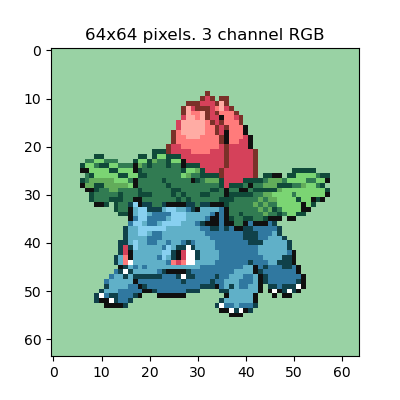

In [6]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(imgs[0])
plt.title("64x64 pixels. 3 channel RGB")
plt.show()

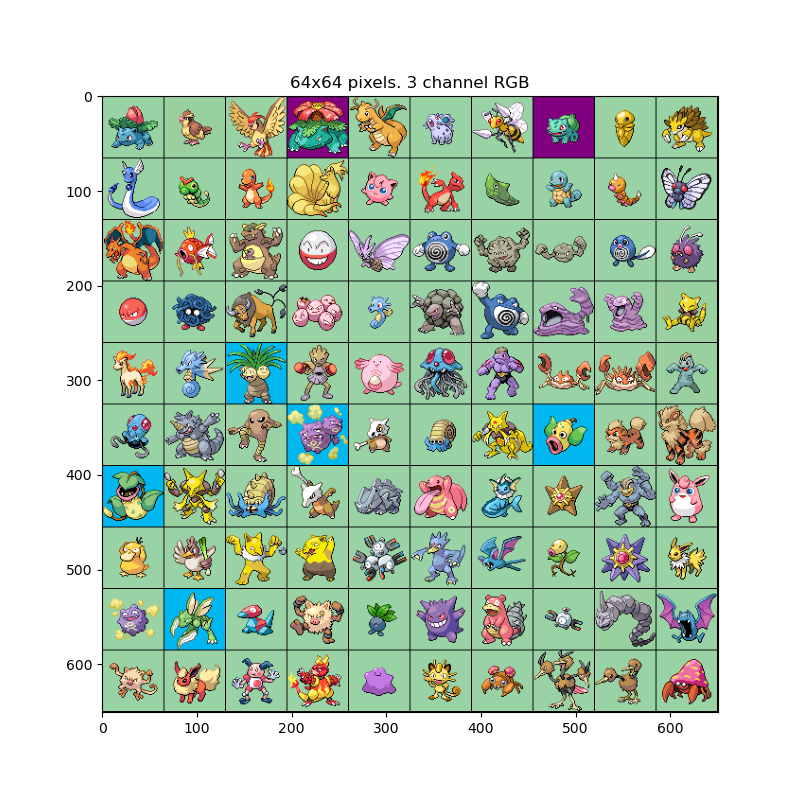

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img_table(imgs[:100]))
plt.title("64x64 pixels. 3 channel RGB")
plt.show()

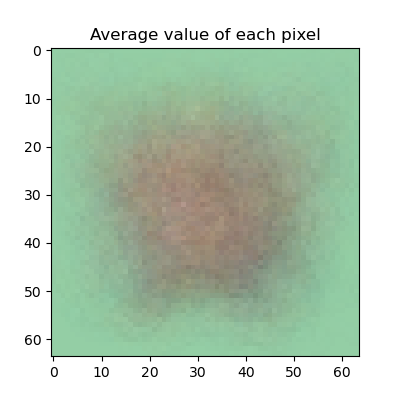

In [8]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(img_mean_pxls(imgs, 0).astype(np.uint8))
plt.title("Average value of each pixel")
plt.show()

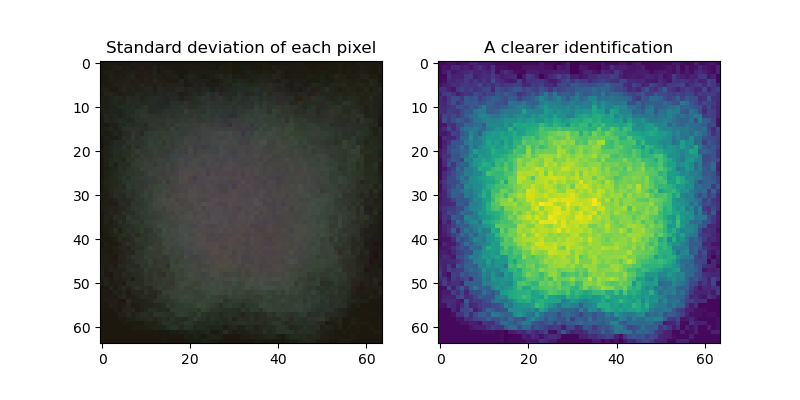

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(img_std_pxls(imgs, 0).astype(np.uint8))
axs[0].set_title("Standard deviation of each pixel")

axs[1].imshow(np.mean(img_std_pxls(imgs, 0).astype(np.uint8), axis=2))
axs[1].set_title("A clearer identification")
plt.show()

In [10]:
normal_imgs = np.array([
    preprocess(img, imgs)
    for img in imgs
])
x_train, x_test = train_test_split(normal_imgs, test_size=0.1, random_state=13)

## Model

In [11]:
from keras.regularizers import L1L2

def build_deep_ae(img_shape, code_size):
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(512, activation=tf.keras.activations.tanh))
    encoder.add(Dense(256, activation=tf.keras.activations.tanh))
    encoder.add(Dense(128,  activation=tf.keras.activations.tanh))
    encoder.add(Dense(64,  activation=tf.keras.activations.tanh, activity_regularizer=L1L2(0.00001, 0)))

    decoder = Sequential()
    decoder.add(InputLayer((64,)))
    decoder.add(Dense(128, activation=tf.keras.activations.tanh))
    decoder.add(Dense(256, activation=tf.keras.activations.tanh))
    decoder.add(Dense(512, activation=tf.keras.activations.tanh))
    decoder.add(Dense(np.prod(img_shape), activation=tf.keras.activations.tanh))
    decoder.add(Reshape(img_shape))

    inp = Input(IMG_SHAPE)
    code = encoder(inp)
    reconstruction = decoder(code)
    autoencoder = Model(inp,reconstruction)
    
    return encoder, decoder, autoencoder

In [18]:
IMG_SHAPE = normal_imgs.shape[1:]
encoder, decoder, autoencoder =  build_deep_ae(IMG_SHAPE, 14)

autoencoder.compile(optimizer='adamax', loss='mean_squared_error')

print(autoencoder.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 64)                6464448   
_________________________________________________________________
sequential_4 (Sequential)    (None, 64, 64, 3)         6476672   
Total params: 12,941,120
Trainable params: 12,941,120
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
history = autoencoder.fit(
    x=x_train, y=x_train,
    epochs=1000,
    shuffle=True,
    validation_data=[x_test, x_test]
)

Train on 135 samples, validate on 16 samples
Epoch 1/1000
135/135 [==============================] - 1s 10ms/step - loss: 0.7842 - val_loss: 0.4937
Epoch 2/1000
135/135 [==============================] - 1s 9ms/step - loss: 0.7788 - val_loss: 0.4919
Epoch 3/1000
135/135 [==============================] - 1s 9ms/step - loss: 0.7734 - val_loss: 0.4908
Epoch 4/1000
135/135 [==============================] - 1s 9ms/step - loss: 0.7677 - val_loss: 0.4834
Epoch 5/1000
135/135 [==============================] - 1s 10ms/step - loss: 0.7622 - val_loss: 0.5030
Epoch 6/1000
135/135 [==============================] - 1s 9ms/step - loss: 0.7584 - val_loss: 0.4863
Epoch 7/1000
135/135 [==============================] - 1s 9ms/step - loss: 0.7537 - val_loss: 0.4942
Epoch 8/1000
135/135 [==============================] - 1s 8ms/step - loss: 0.7488 - val_loss: 0.4925
Epoch 9/1000
135/135 [==============================] - 1s 8ms/step - loss: 0.7442 - val_loss: 0.4925
Epoch 10/1000
135/135 [============

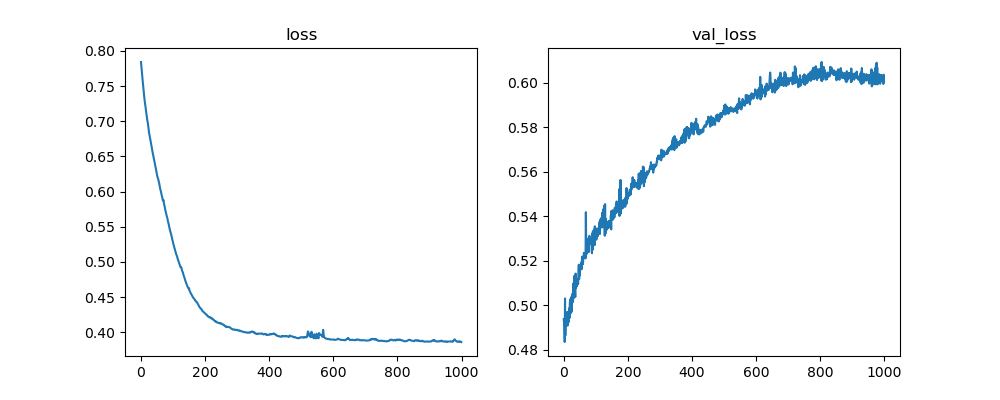

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(history.history['loss'])
axs[0].set_title("loss")
axs[1].plot(history.history['val_loss'])
axs[1].set_title("val_loss")

plt.show()

In [26]:
recs = np.array([
    deprocess(autoencoder.predict(img[None])[0], imgs)
    for img in x_test
])

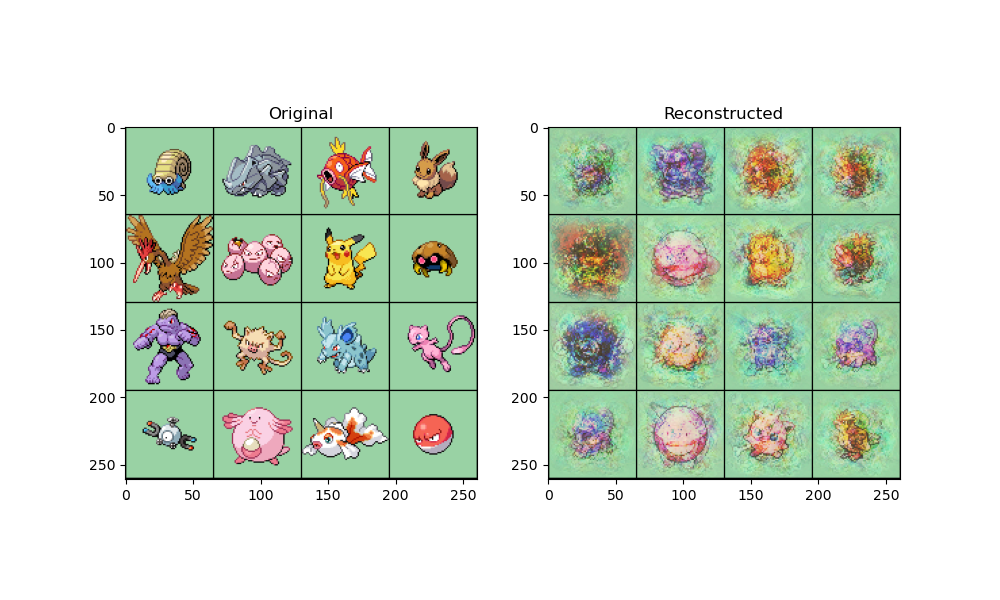

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].imshow(img_table(
    np.array([
        deprocess(img, imgs)
        for img in x_test
    ])
))
axs[0].set_title("Original")

axs[1].imshow(img_table(recs[:100]))
axs[1].set_title("Reconstructed")

plt.show()

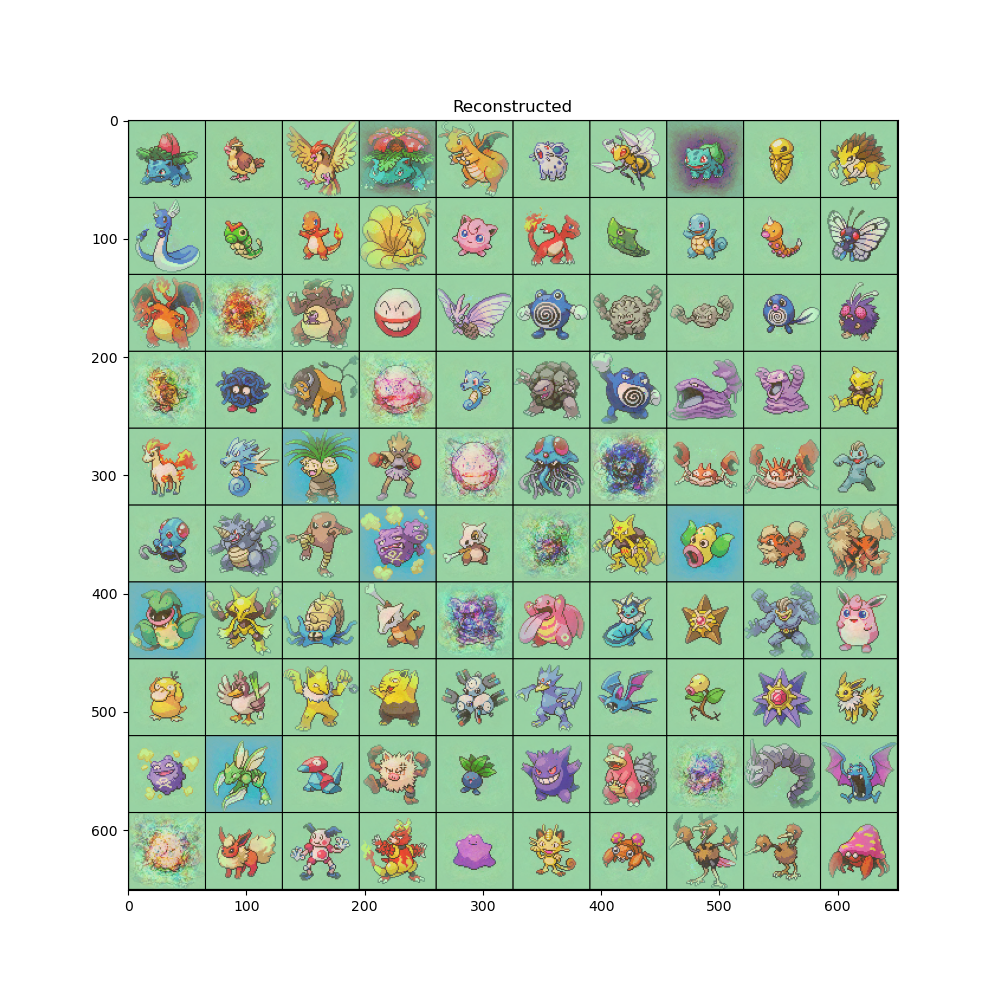

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_table(
    np.array([
        deprocess(autoencoder.predict(img[None])[0], imgs)
        for img in normal_imgs
    ][:100])
))
ax.set_title("Reconstructed")

plt.show()